In [2]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

### Load base models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


100%|██████████| 161M/161M [01:23<00:00, 1.92MiB/s] 


downloading upsampler checkpoint...


<All keys matched successfully>

In [4]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [5]:
# Set a prompt to condition on.
prompt = 'dome home'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

130it [38:22, 17.71s/it]


In [12]:
pointcloud = sampler.output_to_point_clouds(samples)[0]

In [8]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

print('loading SDF model...')
sdf_model = model_from_config(MODEL_CONFIGS['sdf'], device)
sdf_model.eval()
sdf_model.load_state_dict(load_checkpoint('sdf', device))

mesh = marching_cubes_mesh(
    pc=pointcloud,
    model=sdf_model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

loading SDF model...


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [9]:
obj_directory = "homes_data/all_homes_obj"

full_path = obj_directory + "/" + "text_dome_home.obj"
f = open(full_path, "w")
for i in range(len(mesh.verts)):
    f.write("v " + str(mesh.verts[i][0]) + " " + str(mesh.verts[i][1]) + " " + str(mesh.verts[i][2]) + " ")
    f.write("\n")

for i in range(len(mesh.normals)):
    f.write("vn " + str(mesh.normals[i][0]) + " " + str(mesh.normals[i][1]) + " " + str(mesh.normals[i][2]) + " ")
    f.write("\n")

for i in range(len(mesh.faces)):
    f.write("f " + str(mesh.faces[i][0]) + " " + str(mesh.faces[i][1]) + " " + str(mesh.faces[i][2]) + " ")
    f.write("\n")
f.close()

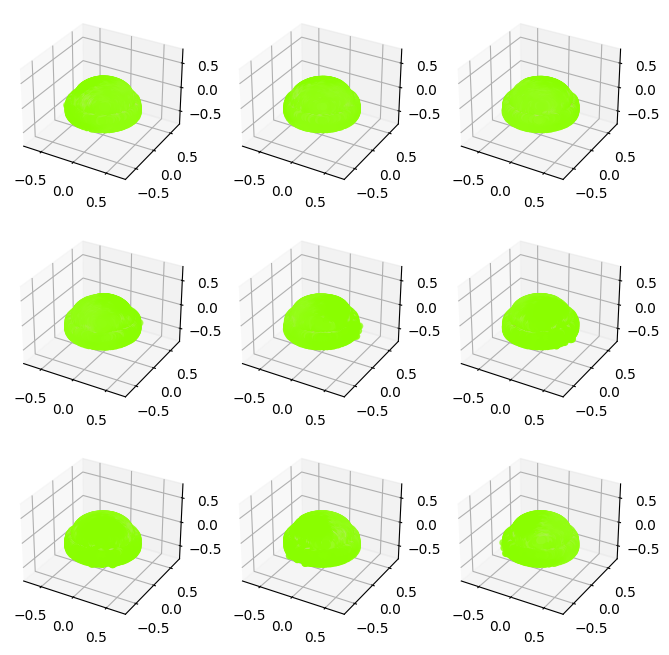

In [13]:
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))